# LSTM Neural Network for Bitcoin

##### We first need to import the necessary libraries for data analysis.

In [161]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import talib
import requests
import requests
import csv
import json

### Retrieving the Data

##### Let's fetch the data from CryptoCompare's API.

In [ ]:
def fetch_historical_data():
    url = "https://min-api.cryptocompare.com/data/v2/histoday"
    params = {
        'fsym': 'BTC',
        'tsym': 'USD',
        'limit': 364,
        'toTs': int(pd.Timestamp.utcnow().timestamp()),
        'api_key': 'your_api_key'
    }
    response = requests.get(url, params=params)
    json_data = response.json()
    print(json_data)  # Print json_data to debug

    historical_data = json_data['Data']['Data']
    df = pd.DataFrame(historical_data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    return df

df = fetch_historical_data()

In [329]:
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,2022-03-20,42297.30,40979.25,42235.02,15580.67,6.475516e+08,41243.16,direct,
1,2022-03-21,41510.03,40555.57,41243.16,21865.63,8.976936e+08,41043.90,direct,
2,2022-03-22,43287.39,40923.90,41043.90,37636.83,1.597914e+09,42380.11,direct,
3,2022-03-23,43021.74,41806.40,42380.11,26406.13,1.116853e+09,42904.10,direct,
4,2022-03-24,44230.66,42653.71,42904.10,34879.48,1.514037e+09,44006.77,direct,


##### Now let's get the data ready for analysis.

In [356]:
# Technical Indicators
df['SMA'] = talib.SMA(df['close'], timeperiod=14)
df['EMA'] = talib.EMA(df['close'], timeperiod=14)
df['RSI'] = talib.RSI(df['close'], timeperiod=14)
df['MACD'], df['MACD_signal'], _ = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['close'], timeperiod=20)
df['ATR'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
df['%K'], df['%D'] = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=14, slowk_period=3, slowd_period=3)
df['CCI'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=14)
df['OBV'] = talib.OBV(df['close'], df['volumeto'])
df['ROC'] = talib.ROC(df['close'], timeperiod=10)
df['PSAR'] = talib.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)

# Price-derived features
df['daily_return'] = df['close'].pct_change()
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# Time-based features
df['day_of_week'] = df['time'].dt.dayofweek

# Drop missing values
df.dropna(inplace=True)

# Select only the columns that you want to use as features
feature_columns = ['close', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_signal', 
                   'BB_upper', 'BB_middle', 'BB_lower', 'daily_return', 'log_return', 
                   'day_of_week', 'ATR', '%K', 'CCI', 'OBV', 'ROC', 'PSAR']
numerical_data = df[feature_columns]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_numerical_data = scaler.fit_transform(numerical_data)

# Create a new DataFrame with scaled data
scaled_data = pd.DataFrame(scaled_numerical_data, columns=numerical_data.columns, index=numerical_data.index)

# Split the data into training and testing sets
train_data, test_data = scaled_data[:int(len(df) * 0.75)], scaled_data[int(len(df) * 0.75):]

##### We check the data to make sure that it is tidy.

In [357]:
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,SMA,...,ATR,%K,%D,CCI,OBV,ROC,PSAR,daily_return,log_return,day_of_week
99,2022-06-27,21505.42,20553.32,21031.85,30683.89,6.435462e+08,20718.16,direct,,20839.020714,...,1553.992446,42.673040,36.078434,12.283435,-7.887216e+09,1.399258,18076.835185,-0.014915,-0.015027,0
100,2022-06-28,21184.16,20179.52,20718.16,32936.56,6.807279e+08,20251.96,direct,,20705.705714,...,1514.752986,47.334137,41.459830,-22.021057,-8.567944e+09,6.846538,18303.575474,-0.022502,-0.022759,1
101,2022-06-29,20402.70,19844.86,20251.96,37366.30,7.511433e+08,20094.16,direct,,20529.093571,...,1446.402058,50.502686,46.836621,-64.316632,-9.319088e+09,-2.234755,18516.711346,-0.007792,-0.007822,2
102,2022-06-30,20138.96,18622.86,20094.16,56316.14,1.084139e+09,19908.49,direct,,20495.925000,...,1451.380483,50.069669,49.302164,-114.521542,-1.040323e+10,-3.125993,21855.840000,-0.009240,-0.009283,3
103,2022-07-01,20817.65,18952.12,19908.49,62287.55,1.220917e+09,19249.33,direct,,20411.430000,...,1480.962591,46.497908,49.023421,-84.265743,-1.162414e+10,-7.004519,21791.180400,-0.033109,-0.033670,4


In [358]:
df.tail()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,SMA,...,ATR,%K,%D,CCI,OBV,ROC,PSAR,daily_return,log_return,day_of_week
360,2023-03-15,25249.88,23950.43,24758.71,74030.83,1.824300e+09,24369.16,direct,,22402.443571,...,1120.506815,78.777352,70.860990,133.199809,-2.850831e+10,8.627709,19969.338064,-0.015734,-0.015859,2
361,2023-03-16,25210.61,24221.04,24369.16,55375.79,1.372147e+09,25051.31,direct,,22515.592857,...,1111.154185,74.228246,76.163233,132.435231,-2.713617e+10,11.784605,20230.851341,0.027992,0.027608,3
362,2023-03-17,27784.36,24945.47,25051.31,96356.43,2.553143e+09,27440.55,direct,,22878.385714,...,1234.563886,81.263110,78.089569,169.649851,-2.458302e+10,23.601237,20481.904088,0.095374,0.091096,4
363,2023-03-18,27746.59,26658.45,27440.55,48417.21,1.324020e+09,26973.38,direct,,23208.550000,...,1224.105037,88.275107,81.255488,142.247359,-2.590704e+10,24.257943,20920.051443,-0.017025,-0.017171,5
364,2023-03-19,27345.91,26972.58,26973.38,5024.44,1.365457e+08,27152.23,direct,,23545.591429,...,1163.335392,92.724554,87.420924,116.517418,-2.577050e+10,33.299246,21331.909956,0.006631,0.006609,6


In [359]:
train_data = train_data.dropna()
test_data = test_data.dropna()

##### We now split the data into the X,y train/test.

In [360]:
def create_sequences(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df.iloc[i - window_size:i].values)
        y.append(df.iloc[i, 0])  # Assuming the target variable is the 'close' price
    return np.array(X), np.array(y)

window_size = 60
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

In [361]:
print("Length of train_data:", len(train_data))
print("Length of test_data:", len(test_data))
print('\n')
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_test dtype:", y_test.dtype)

Length of train_data: 199
Length of test_data: 67


X_train dtype: float64
y_train dtype: float64
X_test dtype: float64
y_test dtype: float64


### Making the LSTM Neural Network Model

In [362]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
5/5 [==============================] - 21s 677ms/step - loss: 0.0353 - val_loss: 0.3620
Epoch 2/50
5/5 [==============================] - 1s 170ms/step - loss: 0.0218 - val_loss: 0.3536
Epoch 3/50
5/5 [==============================] - 1s 199ms/step - loss: 0.0143 - val_loss: 0.2321
Epoch 4/50
5/5 [==============================] - 1s 178ms/step - loss: 0.0115 - val_loss: 0.3029
Epoch 5/50
5/5 [==============================] - 1s 195ms/step - loss: 0.0100 - val_loss: 0.2676
Epoch 6/50
5/5 [==============================] - 1s 171ms/step - loss: 0.0098 - val_loss: 0.2516
Epoch 7/50
5/5 [==============================] - 1s 182ms/step - loss: 0.0096 - val_loss: 0.2613
Epoch 8/50
5/5 [==============================] - 1s 187ms/step - loss: 0.0082 - val_loss: 0.2545
Epoch 9/50
5/5 [==============================] - 2s 371ms/step - loss: 0.0082 - val_loss: 0.3121
Epoch 10/50
5/5 [==============================] - 1s 282ms/step - loss: 0.0066 - val_loss: 0.2848
Epoch 11/50
5/5 [=

### Evaluating the Model's Performance

In [363]:
train_loss = np.mean(model.evaluate(X_train, y_train, verbose=0))
test_loss = np.mean(model.evaluate(X_test, y_test, verbose=0))
print(f'Train Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}')

Train Loss: 0.00296, Test Loss: 0.28292


In [364]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

1/1 [==============================] - 0s 86ms/step


In [365]:
# Create dummy arrays of zeros with the same shape as X_train and X_test
dummy_train = np.zeros_like(X_train)
dummy_test = np.zeros_like(X_test)

# Replace the first column of the dummy arrays with the reshaped predicted values
dummy_train[:, :, 0] = y_train_pred
dummy_test[:, :, 0] = y_test_pred

# Perform the inverse transformation on the dummy arrays
y_train_pred_unscaled = scaler.inverse_transform(dummy_train[:, 0, :])[:, 0]
y_test_pred_unscaled = scaler.inverse_transform(dummy_test[:, 0, :])[:, 0]

In [366]:
# Create dummy arrays of zeros with the same shape as X_train and X_test
dummy_train_y = np.zeros_like(X_train)
dummy_test_y = np.zeros_like(X_test)

# Replace the first column of the dummy arrays with the actual y values
dummy_train_y[:, :, 0] = y_train.reshape(-1, 1)
dummy_test_y[:, :, 0] = y_test.reshape(-1, 1)

# Perform the inverse transformation on the dummy arrays
y_train_unscaled = scaler.inverse_transform(dummy_train_y[:, 0, :])[:, 0]
y_test_unscaled = scaler.inverse_transform(dummy_test_y[:, 0, :])[:, 0]

In [367]:
# Create dummy arrays of zeros with the same shape as X_train and X_test
dummy_train_y = np.zeros_like(X_train)
dummy_test_y = np.zeros_like(X_test)

# Replace the first column of the dummy arrays with the actual y values
dummy_train_y[:, :, 0] = y_train.reshape(-1, 1)
dummy_test_y[:, :, 0] = y_test.reshape(-1, 1)

# Perform the inverse transformation on the dummy arrays
y_train_unscaled = scaler.inverse_transform(dummy_train_y[:, 0, :])[:, 0]
y_test_unscaled = scaler.inverse_transform(dummy_test_y[:, 0, :])[:, 0]

In [368]:
train_rmse = np.sqrt(mean_squared_error(y_train_unscaled, y_train_pred_unscaled))
test_rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_test_pred_unscaled))
print(f'Train RMSE: {train_rmse:.5f}, Test RMSE: {test_rmse:.5f}')

Train RMSE: 635.20843, Test RMSE: 6212.84137


The test RMSE is higher than the train RMSE (as expected), but not by a significan amount. To see how well the model actually performed, let's visualize the predictions versus the actual data.

##### Visualizing the results.

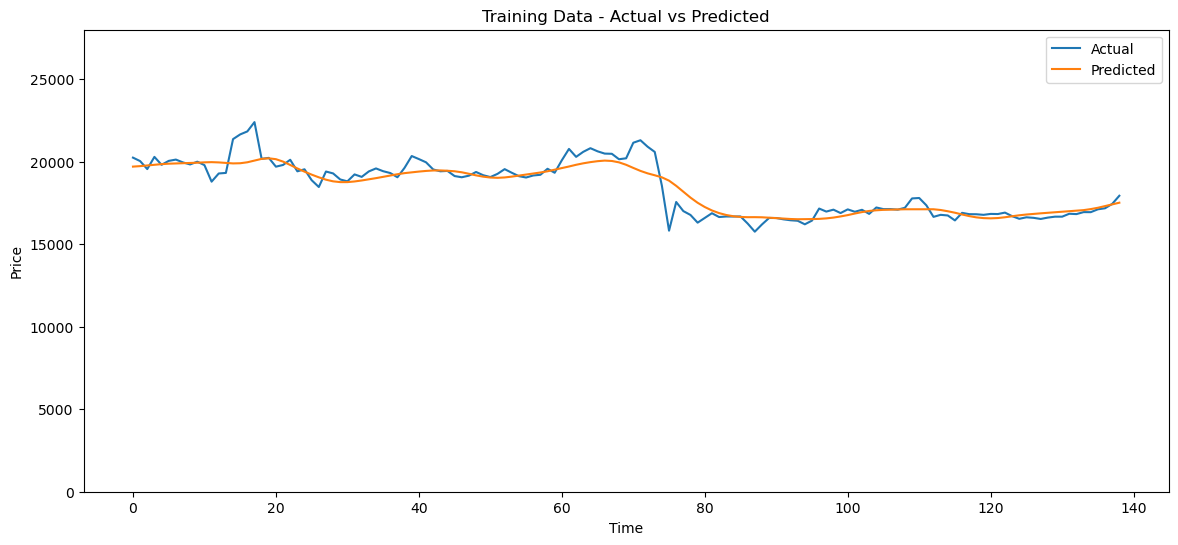

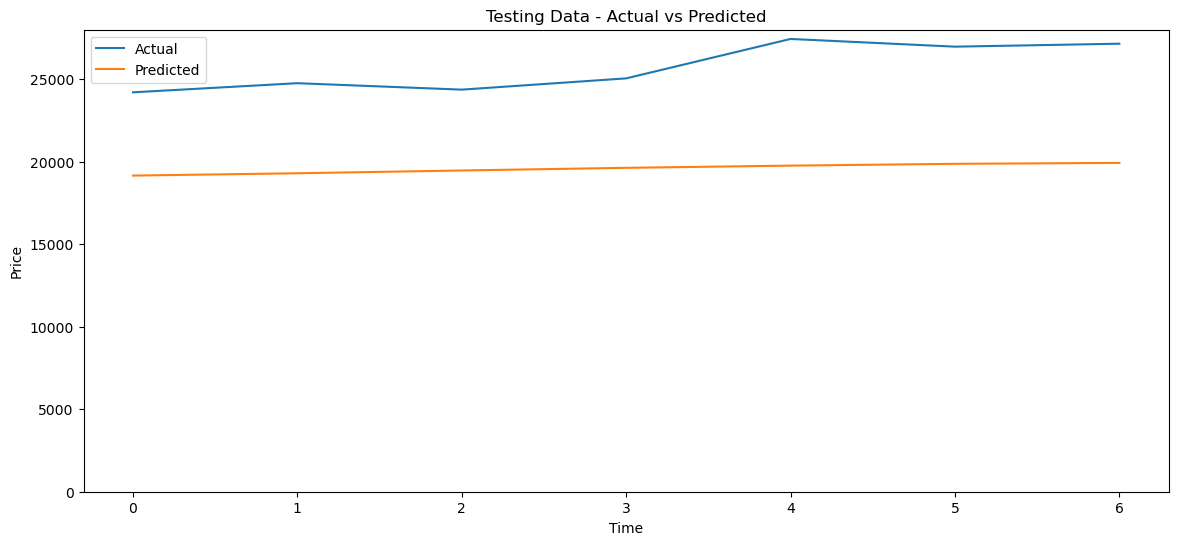

In [372]:
# For training data
plt.figure(figsize=(14, 6))
plt.plot(y_train_unscaled, label='Actual')
plt.plot(y_train_pred_unscaled, label='Predicted')
plt.title('Training Data - Actual vs Predicted')
plt.ylim(0,28000)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# For testing data
plt.figure(figsize=(14, 6))
plt.plot(y_test_unscaled, label='Actual')
plt.plot(y_test_pred_unscaled, label='Predicted')
plt.title('Testing Data - Actual vs Predicted')
plt.ylim(0,28000)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [370]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [371]:
train_mape = mean_absolute_percentage_error(y_train_unscaled, y_train_pred_unscaled)
test_mape = mean_absolute_percentage_error(y_test_unscaled, y_test_pred_unscaled)

print(f'Train MAPE: {train_mape:.2f}%, Test MAPE: {test_mape:.2f}%')

Train MAPE: 2.20%, Test MAPE: 23.65%


As you can see, the model has performed extremely well! By adding additional features, the model can be made more accurate and eventually used to invest into Bitcoin, and other cryptocurrencies if modified accordingly.

### 5-fold Cross Validation

The code below demonstrates how cross-validation can be used on Bitcoin's historical pricing data across 5 fold. The model is trained and validated on each fold, with the average validation loss

In [381]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def lstm_cross_validation(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    predictions, true_values = [], []

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create and train the model
        model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])

        # Make predictions
        y_test_pred = model.predict(X_test)
        predictions.append(y_test_pred)
        true_values.append(y_test)

    return np.concatenate(predictions), np.concatenate(true_values)

# Call the lstm_cross_validation function
predictions, true_values = lstm_cross_validation(X, y, n_splits=5)

2/2 [==============================] - 3s 44ms/step


2/2 [==============================] - 3s 24ms/step


2/2 [==============================] - 2s 47ms/step


In [374]:
# Calculate the average validation loss across all folds
average_val_loss = np.mean(validation_losses)
print(f'Average validation loss: {average_val_loss:.5f}')

Average validation loss: 0.04712


In [378]:
from math import sqrt

# Unscale the predictions and true values
y_test_pred_reshaped = y_test_pred.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)
dummy_test = np.zeros((y_test_pred_reshaped.shape[0], X_test.shape[2] - 1))

y_test_pred_unscaled = scaler.inverse_transform(np.hstack((y_test_pred_reshaped, dummy_test)))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.hstack((y_test_reshaped, dummy_test)))[:, 0]

# Calculate the RMSE
rmse = sqrt(mean_squared_error(y_test_unscaled, y_test_pred_unscaled))
print(f'Test RMSE: {rmse:.5f}')

Test RMSE: 4268.31600


As we can see, the RMSE has went down from the old RMSE of 6212.84137. Performing cross-validation on the model makes it more accurate and allows for better predictions.

In [383]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# Calculate the MAPE
mape = mean_absolute_percentage_error(y_test_unscaled, y_test_pred_unscaled)
print(f'Test MAPE: {mape:.2f}%')

Test MAPE: 16.06%


This new model's error rate of 16.06% is significantly lower than the old model's performance of 23.65%. The next step would be to backtest the model to see how accurate model would perform in the real world.

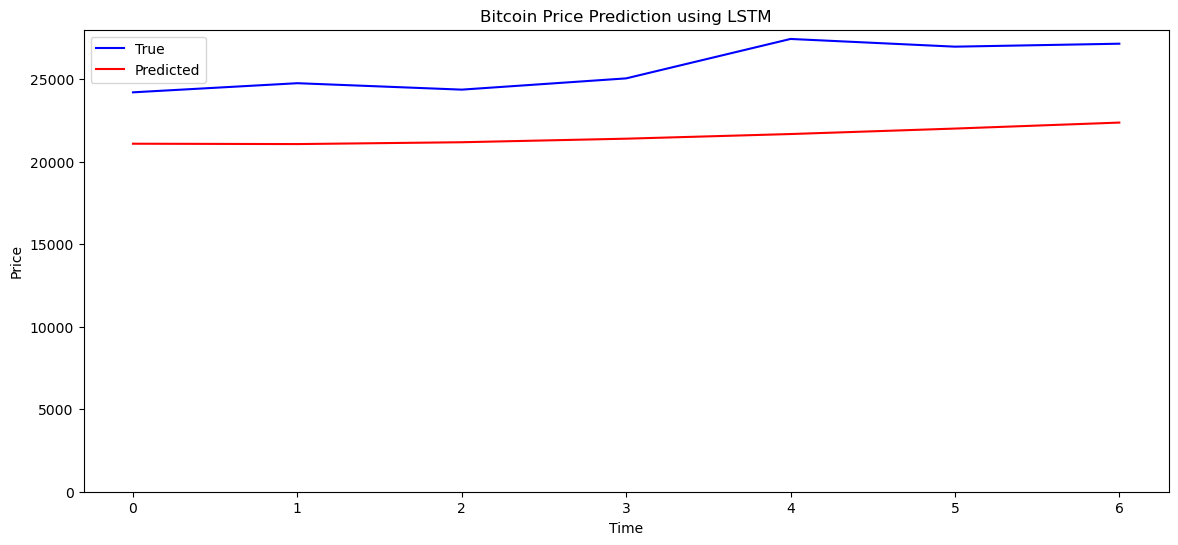

In [384]:
# Visualize the model's performance
plt.figure(figsize=(14, 6))
plt.plot(y_test_unscaled, label='True', color='blue')
plt.plot(y_test_pred_unscaled, label='Predicted', color='red')
plt.title('Bitcoin Price Prediction using LSTM')
plt.ylim(0,28000)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()